In [1]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190812.tar.gz -C ../raw_data

In [2]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190812"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)

pd.set_option('display.max_rows', 90)
# print(df)

In [3]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

# print(samples)

In [4]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

QCfilter = stds['sample'].str.match('QC') # Drop rows that are QC
QC = stds[QCfilter]
stds = stds[~QCfilter]

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)
print(QC)

                           sample  N2O_peak  CO2_peak  CH4_peak        ppm
0    CH4Std_100ppm_8122019_13.txt     86362   1202322     56964    100.000
1     CH4Std_10ppm_8122019_12.txt     51873   2159402     22917     10.000
2      CH4Std_2ppm_8122019_11.txt     24058     60343     18566      2.000
3   CH4Std_5030ppm_8122019_14.txt     44354    444485  10014107   5030.000
4   CO2Std_10100ppm_8122019_4.txt     48327  19229554         0  10100.000
5    CO2Std_1010ppm_8122019_3.txt     51366   2287979         0   1010.000
6   CO2Std_50000ppm_8122019_5.txt     58047  58393090      3005  50000.000
7     CO2Std_500ppm_8122019_2.txt     48406   1239688         0    500.000
59  N2OStd_0101ppm_8122019_25.txt     48947    451095      3072      0.101
60    N2OStd_05ppm_8122019_26.txt     93473    285446      3261      0.500
61    N2OStd_10ppm_8122019_28.txt    906697    523787      2838     10.000
62     N2OStd_1ppm_8122019_27.txt    172468    124931         0      1.000
63    N2OStd_80ppm_812201

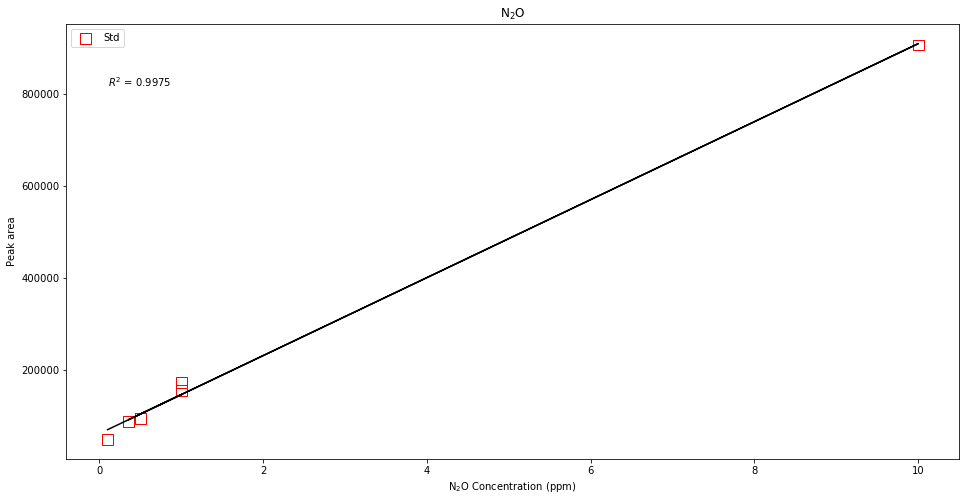

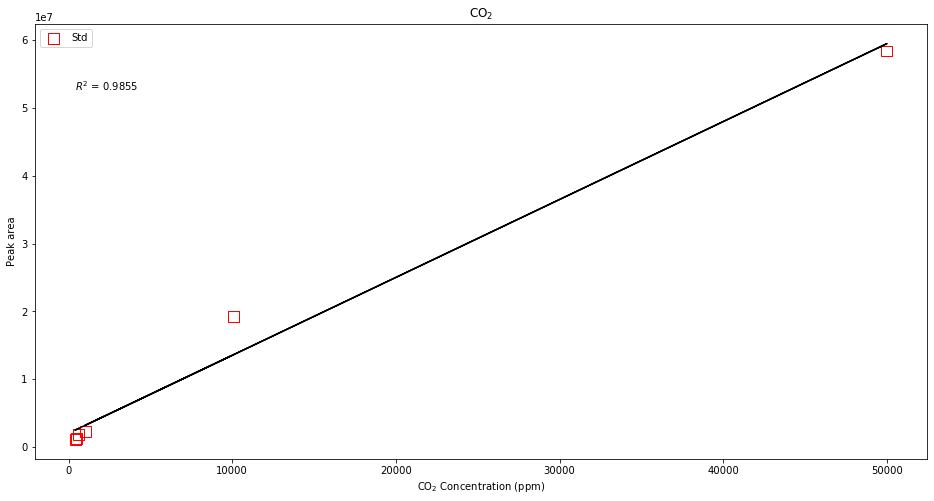

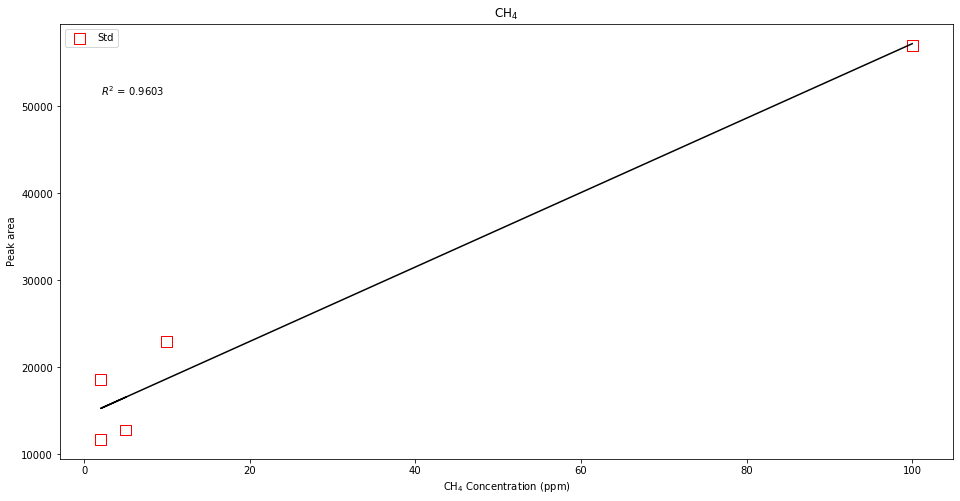

In [5]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Get index of QC's
i = QC.index[QC['sample'] == 'QC-CO2Std_400ppm-CH4Std_2ppm-N2OStd_036ppm_8122019_1.txt']
j = QC.index[QC['sample'] == 'QC-CO2Std_605ppm-CH4Std_5ppm-N2O_1ppm_8122019_69.txt']


# Play around with CH4 standard curve
CH4std = CH4std[~CH4std['sample'].str.contains('5030ppm')] # Drop 5000 ppm since no samples are above 10 ppm
CH4std = CH4std.append({'ppm': 2., 'CH4_peak': QC.loc[i, 'CH4_peak'].values[0]}, ignore_index=True)
CH4std = CH4std.append({'ppm': 5., 'CH4_peak': QC.loc[j, 'CH4_peak'].values[0]}, ignore_index=True)

# Play around with N2O standard curve 
N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_80ppm')] # Drop 80 ppm since no samples are above 10 ppm
# N2Ostd = N2Ostd[~N2Ostd['sample'].str.contains('_1ppm')] # Drop 1 ppm as well -- it looks high
N2Ostd = N2Ostd.append({'ppm': 0.36, 'N2O_peak': QC.loc[i, 'N2O_peak'].values[0]}, ignore_index=True)
N2Ostd = N2Ostd.append({'ppm': 1.0, 'N2O_peak': QC.loc[j, 'N2O_peak'].values[0]}, ignore_index=True)

# Play around with CO2 standard curve
# CO2std = CO2std[~CO2std['sample'].str.contains('_50000ppm')] # Could drop 50000 and get a better curve
# CO2std = CO2std[~CO2std['sample'].str.contains('_10100ppm')] # Or 10100 
CO2std = CO2std.append({'ppm': 400, 'CO2_peak': QC.loc[i, 'CO2_peak'].values[0]}, ignore_index=True)
CO2std = CO2std.append({'ppm': 605, 'CO2_peak': QC.loc[j, 'CO2_peak'].values[0]}, ignore_index=True)

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],r'N$_2$O')
plot_standards(CO2std['ppm'],CO2std['CO2_peak'],r'CO$_2$')
plot_standards(CH4std['ppm'],CH4std['CH4_peak'],r'CH$_4$')

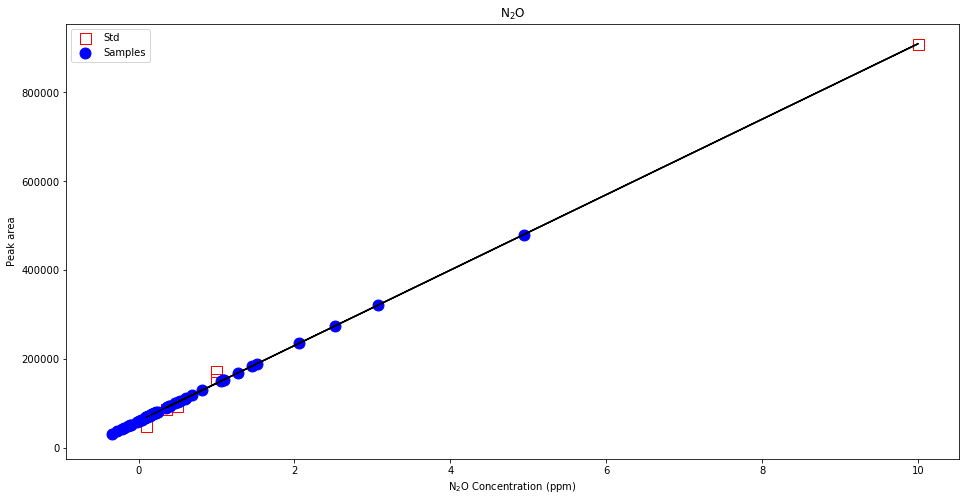

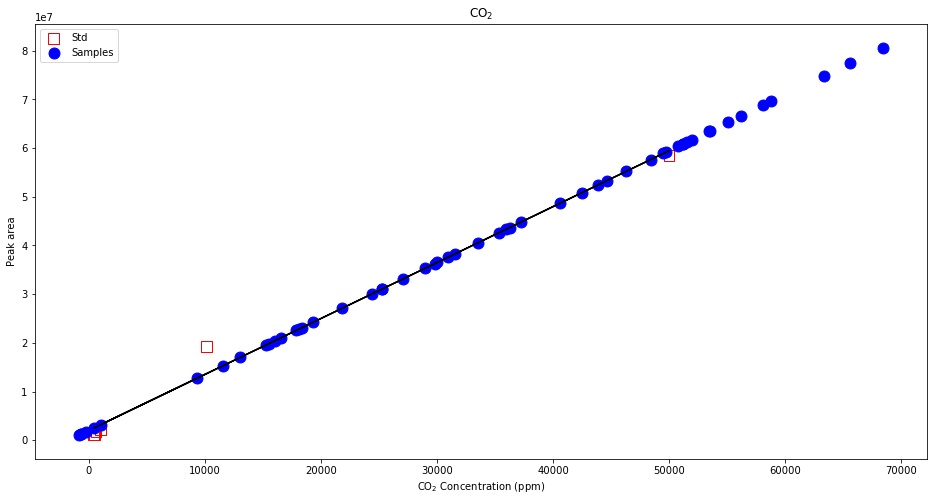

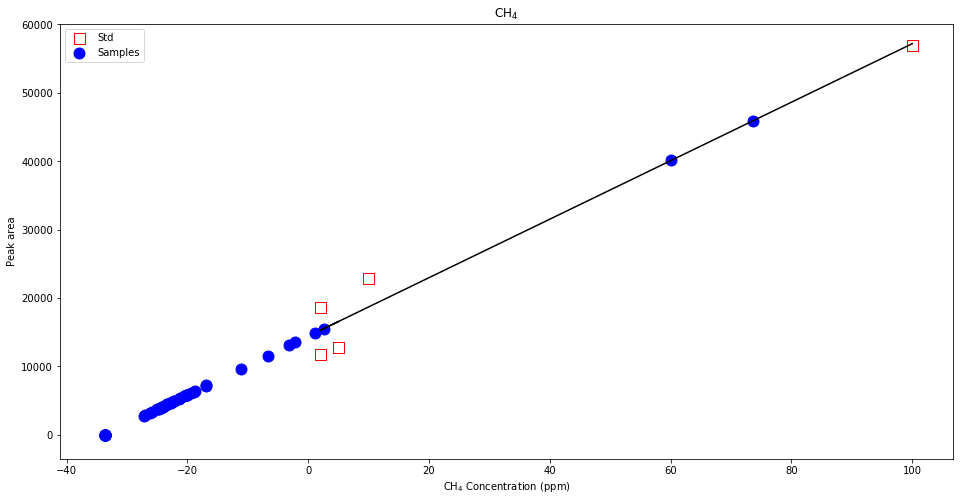

In [6]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], r"N$_2$O")
plot_samples(samples['CO2_peak'], CO2std['ppm'], CO2std['CO2_peak'], r"CO$_2$")
plot_samples(samples['CH4_peak'], CH4std['ppm'], CH4std['CH4_peak'], "CH$_4$")

In [7]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190812.txt", 
                                 write_to_datafile=True)
print(saveoutput)

   vial    location depth       date method    dup  N2O_conc  N2O_bdl  \
8    15  Atmosphere     0 2019-07-29      G  False  0.050500     True   
9    34        NTC1   110 2019-07-29      H  False  1.269767    False   
10   35        NTC1   140 2019-07-29      H  False  0.050500     True   
11   31        NTC1    20 2019-07-29      H  False  0.229371    False   
12   32        NTC1    50 2019-07-29      H  False  0.400748    False   
13   33        NTC1    80 2019-07-29      H  False  1.059878    False   
14   30        NTT1   120 2019-07-29      H  False  0.050500     True   
15   22        NTT1    30 2019-07-29      G  False  0.050500     True   
16   23        NTT1    60 2019-07-29      G  False  0.690994    False   
17   24        NTT1    90 2019-07-29      H  False  1.456377    False   
18   16        Pit1   115 2019-07-29      G  False  0.111750    False   
19   17        Pit1   170 2019-07-29      H  False  0.050500     True   
20   18        Pit1   210 2019-07-29      H  False 